# Project 2

Consistency of results should improve training for a larger number of episodes.

In [1]:
import gym
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#initiliaze Q values using Neural Net
class Net(nn.Module):
    def __init__(self, feature_sz, output_sz):
        super(Net, self).__init__()
        #layers have random initial weights by default
        #input to NN is state space
        self.fc1 = nn.Linear(feature_sz, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 30)
        self.relu2 = nn.ReLU()
        #final output will be Q values - one for each of the actions
        self.fc3 = nn.Linear(30, output_sz)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [91]:
class DQN_GymDiscrete(object):
    def __init__(self, gym_env="LunarLander-v2", proc="cpu"):
        self.env = gym.make(gym_env)
        self.num_states = len(self.env.observation_space.sample())
        self.num_actions = self.env.action_space.n
        self.proc = proc
        #initiliaze Q values using Neural Net
        self.train_net = Net(feature_sz=self.num_states, output_sz=self.num_actions)
        self.targ_net = Net(feature_sz=self.num_states, output_sz=self.num_actions)
    
    def epsilon_decay(self, epsilon, epsilon_start, epsilon_end, curr_ep, episodes, mode="linear"):
        if epsilon <= epsilon_end: #no decay
            return epsilon
        progress = curr_ep / episodes
        if mode == "linear":
            epsilon_distance = epsilon_start - epsilon_end 
            epsilon = epsilon_start - (epsilon_distance * progress) #continous epsilon decay
        elif mode == "staggered":
            if progress > .9:
                epsilon = epsilon_end
            elif progress > .75:
                epsilon = .2
            elif progress > .5:
                epsilon = .3
            elif progress > .3:
                epsilon = .5
            else:
                epsilon = 1
        elif (mode == "decay") and (epsilon > epsilon_end):
            epsilon *= .99995
        return epsilon
    
    def evaluate(self, n_episodes=100, epsilon=0):
        #check gpu
        device = torch.device("cuda:0" if (torch.cuda.is_available() and self.proc == "gpu") else "cpu")
        with torch.no_grad():
            total_reward = np.zeros(n_episodes) #metric
            for ep in range(0, n_episodes):
                ep_reward = 0 #reward for the whole episode
                s = torch.as_tensor(self.env.reset(), device=device).float() #set starting state from gym
                looping = True #break condition
                while looping: #repeat state and actions until terminal state (gym returns done)
                    #if (ep+1) % 11 == 0:
                        #self.env.render()
                    a = 0
                    if np.random.random() < epsilon: #choose action epsilon-greedily
                        a = self.env.action_space.sample() #random action
                    else:
                        a = int(torch.argmax(self.train_net(s))) #action (idx of tensor) of max Q value returned by NN between all actions
                    next_s, reward, done, _ = self.env.step(a) #step; observe s' and reward
                    next_s = torch.as_tensor(next_s, device=device).float()
                    ep_reward += reward
                    if done:
                        looping = False
                    else:
                        s = next_s
                total_reward[ep] = ep_reward
            self.env.close()
        return total_reward

    def train(self, train_episodes=300, explor_episodes=200, alpha=.001, epsilon_start=.7, epsilon_end=0.05, epsilon_mode="linear", 
              gamma=.995, fill_replay_episodes=15, replay_max_size=10000, targ_update=1000, batch_size=32):
        #initialize identical Net to serve as target
        self.targ_net.load_state_dict(self.train_net.state_dict())
        
        #initialize memory replay buffer D
        #we probably won't have space contraints, so we're just going to make this store everything
        #and not deal with replacing array elements
        D = []
        D_idx = 0 #this will count sequences over all training
        training = False #flag for when training starts
        total_eps = fill_replay_episodes + train_episodes
        total_reward = np.zeros(train_episodes) #metric
        rolling_avg_reward = np.zeros(train_episodes) #metric
        epsilon = epsilon_start
        curr_train_ep = 0
        solved = False #for evaluation
        best_mean = 200 #evaluation criteria
        solved_ep = train_episodes
        final_eval_reward = np.zeros(100)
        PATH = "C:/Users/Trevor/Google Drive (tskelton@asu.edu)/Education/GATech/Reinforcement Learning/Project 2/model.pt"
        eval_mean = -100
        
        #check gpu
        device = torch.device("cuda:0" if (torch.cuda.is_available() and self.proc == "gpu") else "cpu")
        print("training on:", device)
        if device == "cuda:0":
            self.train_net = self.train_net.cuda()
            self.targ_net = self.targ_net.cuda()
        self.train_net.to(device)
        self.targ_net.to(device)
        
        #set criterion and optimizer
        criterion = nn.MSELoss()
        criterion = criterion.to(device)
        optimizer = optim.RMSprop(self.train_net.parameters(), lr=alpha)
        #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.99)

        for ep in range(0, total_eps):
            #print("----------Starting Episode {0}---------- \n".format(ep))
            #st=time.time()
            #D_start = D_idx   
            s = torch.as_tensor(self.env.reset(), device=device).float() #set starting state from gym
            ep_reward = 0
            looping = True #break condition
            while looping: #repeat state and actions until terminal state (gym returns done)
                if training == False and (ep >= fill_replay_episodes):
                    training = True
                #set epsilon and choose action
                epsilon = self.epsilon_decay(epsilon, epsilon_start, epsilon_end, curr_train_ep, explor_episodes, epsilon_mode)
                a = 0
                if (ep < fill_replay_episodes) or (np.random.random() < epsilon): #choose action epsilon-greedily, or before training
                    a = torch.as_tensor(self.env.action_space.sample(), device=device) #random action
                else:
                    a = torch.argmax(self.train_net(s)) #action (idx of tensor) of max Q value returned by NN between all actions
                next_s, reward, done, _ = self.env.step(int(a)) #step; observe s' and reward
                next_s = torch.as_tensor(next_s, device=device).float()
                ep_reward += reward
                reward = torch.as_tensor(reward, device=device)
                #take care of cases where episode ends but not terminal (time out due to time steps = 1000)
                non_terminal = True
                if done and abs(reward) == 100: #only for true terminal state, not when done because of timeout
                    non_terminal = False
                non_terminal = torch.as_tensor(non_terminal,device=device)
                #total_reward += reward
                
                #store sequence into replay buffer.
                D.append([s, a, next_s, reward, non_terminal])
                
                #once we have enough sequences to sample from in D, start training
                if training:
                    if (D_idx % 1000) == 0:
                        print('D_idx {0}; lr: {1}; epsilon: {2}'.format(D_idx, optimizer.param_groups[0]['lr'], epsilon))
                    #randomly sample D for this minibatch
                    batch_idxs = []
                    if D_idx < replay_max_size:
                        batch_idxs = np.random.choice([i for i in range(0, D_idx-1)], size=batch_size, replace=False)
                    else: #select from only replay_max_size most recent sequences
                        batch_idxs = np.random.choice([i for i in range(D_idx - replay_max_size, D_idx-1)], size=batch_size, replace=False)

                    #perform gradient descent step
                    states, actions, next_states, rewards, non_terminals = [], [], [], [], [] #initalize lists to store minibatch of data
                    minibatch = [states, actions, next_states, rewards, non_terminals]
                    for idx in batch_idxs:
                        for i, listl in enumerate(minibatch):
                            listl.append(D[idx][i]) #gather D into separate lists for minibatch
                        #b_state, b_action, b_next_state, b_reward, b_terminal = D[idx] #unpack D
                    states = torch.stack(states).float()
                    states = states.to(device)
                    actions = torch.stack(actions).long()
                    next_states = torch.stack(next_states).float()
                    next_states = next_states.to(device)
                    rewards = torch.stack(rewards)
                    non_terminals = torch.stack(non_terminals)
                    
                    #print(states.shape, actions.shape, next_states.shape, rewards.shape, non_terminals.shape)
                    outputs = self.train_net(states)  
                    #baseline of current Q values. Training on this will lead to 0 weight changes for all actions
                    labels = outputs.clone().detach() 
                    
                    #take best action's Q value from next state - or just reward if terminal; 0 index is values, 1 is indices for max
                    Q_max_action = torch.max(self.targ_net(next_states), dim=1)[0]
                    #print(labels[range(labels.shape[0]), actions].shape, rewards.shape, Q_max_action.shape, terminals.shape)
                    #only learning in the action taken; index into y tensor with action a
                    #if terminal, non_terminal = 0 and only reward is the label
                    labels[range(labels.shape[0]), actions] = (rewards + (gamma * Q_max_action * non_terminals)).float()
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    #scheduler.step()
                    
                    #once training started, every targ_update (C) time steps, reset targ net == train net
                    if D_idx % targ_update == 0:
                        #print("At D_idx: {0} time steps, copied train_net into target\n".format(D_idx))
                        self.targ_net.load_state_dict(self.train_net.state_dict())
                        
                D_idx += 1 #update D counter before possibly exiting episode
                if done:
                    looping = False #end of episode
                else:
                    s = next_s
                    
            if training:
                curr_train_ep = ep - fill_replay_episodes
                total_reward[curr_train_ep] = ep_reward
                #print("Training Episode {0}; Reward = {1}; Ep {2}".format(curr_train_ep, ep_reward, ep))
                f = max(curr_train_ep - 99, 0)
                to = curr_train_ep + 1
                rolling_avg_reward[curr_train_ep] = np.mean(total_reward[f:to])
                print("Rolling avg reward (past 100 after training, from {0} to {1}): {2}".format(f, to, rolling_avg_reward[curr_train_ep]))

            #D_end = D_idx
            #e = time.time()
            #print("Episode took {0} s to perform {1} steps; {2} steps per s".format(e - st, D_end-D_start, (D_end-D_start)/(e-st)))
        self.env.close()
        if solved:
            self.train_net.load_state_dict(torch.load(PATH))
        return total_reward, rolling_avg_reward, final_eval_reward, solved_ep

In [104]:
%%time
model_05 = DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 200

total_reward_05, rolling_avg_reward_05, eval_reward_05, solved_ep_05 = model_05.train(train_episodes=train_episodes,
                                                                                     explor_episodes=train_episodes, 
                                                                                     alpha=.001, 
                                                                                     epsilon_start=.7, 
                                                                                     epsilon_end=.05, 
                                                                                     epsilon_mode="linear", 
                                                                                     gamma=.995, 
                                                                                     fill_replay_episodes=32,
                                                                                     replay_max_size=10000, #
                                                                                     targ_update=100,
                                                                                     batch_size=64)

training on: cpu
D_idx 3000; lr: 0.001; epsilon: 0.7
Rolling avg reward (past 100 after training, from 0 to 1): -276.4500397147309
Rolling avg reward (past 100 after training, from 0 to 2): -184.7924678959689
Rolling avg reward (past 100 after training, from 0 to 3): -207.7853531046644
Rolling avg reward (past 100 after training, from 0 to 4): -171.23524518002677
Rolling avg reward (past 100 after training, from 0 to 5): -141.32592576643728
Rolling avg reward (past 100 after training, from 0 to 6): -130.5658492282422
Rolling avg reward (past 100 after training, from 0 to 7): -160.77366624289584
Rolling avg reward (past 100 after training, from 0 to 8): -168.55694524281205
Rolling avg reward (past 100 after training, from 0 to 9): -159.24803820916588
Rolling avg reward (past 100 after training, from 0 to 10): -147.20206655992928
Rolling avg reward (past 100 after training, from 0 to 11): -149.37806507310142
D_idx 4000; lr: 0.001; epsilon: 0.6675
Rolling avg reward (past 100 after traini

D_idx 22000; lr: 0.001; epsilon: 0.40099999999999997
Rolling avg reward (past 100 after training, from 0 to 94): -73.3669170257005
D_idx 23000; lr: 0.001; epsilon: 0.39775
Rolling avg reward (past 100 after training, from 0 to 95): -72.33160970002896
D_idx 24000; lr: 0.001; epsilon: 0.3945
Rolling avg reward (past 100 after training, from 0 to 96): -73.34111939430959
Rolling avg reward (past 100 after training, from 0 to 97): -73.92697941264368
D_idx 25000; lr: 0.001; epsilon: 0.388
Rolling avg reward (past 100 after training, from 0 to 98): -72.79973902679205
Rolling avg reward (past 100 after training, from 0 to 99): -72.37899651757478
D_idx 26000; lr: 0.001; epsilon: 0.3815
Rolling avg reward (past 100 after training, from 0 to 100): -70.91300769631897
D_idx 27000; lr: 0.001; epsilon: 0.37825
Rolling avg reward (past 100 after training, from 1 to 101): -67.26026439572742
Rolling avg reward (past 100 after training, from 2 to 102): -66.54378303498143
D_idx 28000; lr: 0.001; epsilon: 

Rolling avg reward (past 100 after training, from 67 to 167): -4.285048276146811
Rolling avg reward (past 100 after training, from 68 to 168): -4.090064031426924
Rolling avg reward (past 100 after training, from 69 to 169): -0.9745264903525075
D_idx 72000; lr: 0.001; epsilon: 0.15400000000000003
Rolling avg reward (past 100 after training, from 70 to 170): 2.7657239417059816
D_idx 73000; lr: 0.001; epsilon: 0.15075000000000005
Rolling avg reward (past 100 after training, from 71 to 171): 4.498923106410608
Rolling avg reward (past 100 after training, from 72 to 172): 2.041759620564767
Rolling avg reward (past 100 after training, from 73 to 173): 1.8998644851306643
Rolling avg reward (past 100 after training, from 74 to 174): 1.736268836454029
D_idx 74000; lr: 0.001; epsilon: 0.13775000000000004
Rolling avg reward (past 100 after training, from 75 to 175): 6.041675122747444
Rolling avg reward (past 100 after training, from 76 to 176): 9.048535643432738
Rolling avg reward (past 100 after 

In [69]:
%%time
model_recency12 = DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 250
total_reward, rolling_avg_reward, eval_reward, solved_ep = model_recency12.train(train_episodes=train_episodes,
                                                                                 explor_episodes=train_episodes, 
                                                                                 alpha=.001, 
                                                                                 epsilon_start=1, 
                                                                                 epsilon_end=.05, 
                                                                                 epsilon_mode="linear", 
                                                                                 gamma=.995, 
                                                                                 fill_replay_episodes=32,
                                                                                 replay_max_size=10000,
                                                                                 targ_update=1000,
                                                                                 batch_size=32)

training on: cpu
D_idx 3000; lr: 0.0005; epsilon: 1.0
D_idx 4000; lr: 0.0005; epsilon: 0.9616
D_idx 5000; lr: 0.0005; epsilon: 0.9296
D_idx 6000; lr: 0.0005; epsilon: 0.8944
D_idx 7000; lr: 0.0005; epsilon: 0.8624
D_idx 8000; lr: 0.0005; epsilon: 0.8336
D_idx 9000; lr: 0.0005; epsilon: 0.8016
D_idx 10000; lr: 0.0005; epsilon: 0.7728
D_idx 11000; lr: 0.0005; epsilon: 0.7407999999999999
D_idx 12000; lr: 0.0005; epsilon: 0.7152000000000001
D_idx 13000; lr: 0.0005; epsilon: 0.712
D_idx 14000; lr: 0.0005; epsilon: 0.6863999999999999
Evaluation starting at Epsiode 99
Mean: -106.05109727687204, Median: -111.1069963687581
D_idx 15000; lr: 0.0005; epsilon: 0.6608
Evaluation starting at Epsiode 109
Mean: -98.46445977922016, Median: -92.53387972834257
D_idx 16000; lr: 0.0005; epsilon: 0.6384
Evaluation starting at Epsiode 119
Mean: -122.71876859691645, Median: -124.23049198770305
D_idx 17000; lr: 0.0005; epsilon: 0.6128
D_idx 18000; lr: 0.0005; epsilon: 0.5904
Evaluation starting at Epsiode 129
M

In [107]:
filename="model_05"
PATH = "C:/Users/Trevor/Google Drive (tskelton@asu.edu)/Education/GATech/Reinforcement Learning/Project 2/{}.pt".format(filename)
torch.save(model_05.train_net.state_dict(), PATH)

In [93]:
%%time
model_recency_04 = DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 250
total_reward_04, rolling_avg_reward_04, eval_reward_04, solved_ep_04 = model_recency_04.train(train_episodes=train_episodes,
                                                                                              explor_episodes=train_episodes, 
                                                                                              alpha=.001, 
                                                                                              epsilon_start=.7, 
                                                                                              epsilon_end=.05, 
                                                                                              epsilon_mode="linear", 
                                                                                              gamma=.995, 
                                                                                              fill_replay_episodes=32,
                                                                                              replay_max_size=50000, #
                                                                                              targ_update=100,
                                                                                              batch_size=32)

training on: cpu
D_idx 3000; lr: 0.001; epsilon: 0.7
D_idx 4000; lr: 0.001; epsilon: 0.6818
D_idx 5000; lr: 0.001; epsilon: 0.6609999999999999
D_idx 6000; lr: 0.001; epsilon: 0.6402
D_idx 7000; lr: 0.001; epsilon: 0.6194
D_idx 8000; lr: 0.001; epsilon: 0.5986
D_idx 9000; lr: 0.001; epsilon: 0.5751999999999999
D_idx 10000; lr: 0.001; epsilon: 0.5544
D_idx 11000; lr: 0.001; epsilon: 0.5414
D_idx 12000; lr: 0.001; epsilon: 0.5284
D_idx 13000; lr: 0.001; epsilon: 0.5128
D_idx 14000; lr: 0.001; epsilon: 0.505
D_idx 15000; lr: 0.001; epsilon: 0.4946
D_idx 16000; lr: 0.001; epsilon: 0.48419999999999996
D_idx 17000; lr: 0.001; epsilon: 0.4712
D_idx 18000; lr: 0.001; epsilon: 0.4608
D_idx 19000; lr: 0.001; epsilon: 0.4504
D_idx 20000; lr: 0.001; epsilon: 0.4452
D_idx 21000; lr: 0.001; epsilon: 0.44
D_idx 22000; lr: 0.001; epsilon: 0.43220000000000003
D_idx 23000; lr: 0.001; epsilon: 0.4296
D_idx 24000; lr: 0.001; epsilon: 0.4244
D_idx 25000; lr: 0.001; epsilon: 0.4218
D_idx 26000; lr: 0.001; ep

In [102]:
filename="model_recency_04"
PATH = "C:/Users/Trevor/Google Drive (tskelton@asu.edu)/Education/GATech/Reinforcement Learning/Project 2/{}.pt".format(filename)
torch.save(model_recency_04.train_net.state_dict(), PATH)

In [91]:
%%time
model_recency_03 = DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 250
total_reward_03, rolling_avg_reward_03, eval_reward_03, solved_ep_03 = model_recency_03.train(train_episodes=train_episodes,
                                                                                              explor_episodes=train_episodes, 
                                                                                              alpha=.001, 
                                                                                              epsilon_start=.7, 
                                                                                              epsilon_end=.05, 
                                                                                              epsilon_mode="linear", 
                                                                                              gamma=.995, 
                                                                                              fill_replay_episodes=32,
                                                                                              replay_max_size=200000, #
                                                                                              targ_update=100,
                                                                                              batch_size=32)

training on: cpu
D_idx 4000; lr: 0.001; epsilon: 0.9696
D_idx 5000; lr: 0.001; epsilon: 0.9316
D_idx 6000; lr: 0.001; epsilon: 0.8974
D_idx 7000; lr: 0.001; epsilon: 0.8632
D_idx 8000; lr: 0.001; epsilon: 0.8214
D_idx 9000; lr: 0.001; epsilon: 0.7872
D_idx 10000; lr: 0.001; epsilon: 0.753
D_idx 11000; lr: 0.001; epsilon: 0.7226
D_idx 12000; lr: 0.001; epsilon: 0.696
D_idx 13000; lr: 0.001; epsilon: 0.6656
D_idx 14000; lr: 0.001; epsilon: 0.639
Evaluation starting at Epsiode 99
Mean: -180.12422169258303, Median: -179.5414896732884
D_idx 15000; lr: 0.001; epsilon: 0.6086
Evaluation starting at Epsiode 109
Mean: -164.34767930735862, Median: -170.98490906244447
D_idx 16000; lr: 0.001; epsilon: 0.5858000000000001
D_idx 17000; lr: 0.001; epsilon: 0.5706
Evaluation starting at Epsiode 119
Mean: -165.31122936434195, Median: -170.45248775368543
D_idx 18000; lr: 0.001; epsilon: 0.5478000000000001
D_idx 19000; lr: 0.001; epsilon: 0.5288
Evaluation starting at Epsiode 129
Mean: -160.92446044123685

In [103]:
filename="model_recency_03"
PATH = "C:/Users/Trevor/Google Drive (tskelton@asu.edu)/Education/GATech/Reinforcement Learning/Project 2/{}.pt".format(filename)
torch.save(model_recency_03.train_net.state_dict(), PATH)

In [83]:
%%time
model_recency_01 = DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 250
total_reward_01, rolling_avg_reward_01, eval_reward_01, solved_ep_01 = model_recency_04.train(train_episodes=train_episodes,
                                                                                              explor_episodes=train_episodes, 
                                                                                              alpha=.001, 
                                                                                              epsilon_start=.7, 
                                                                                              epsilon_end=.05, 
                                                                                              epsilon_mode="linear", 
                                                                                              gamma=.998, #
                                                                                              fill_replay_episodes=32,
                                                                                              replay_max_size=10000,
                                                                                              targ_update=100,
                                                                                              batch_size=32)

training on: cpu
D_idx 3000; lr: 0.001; epsilon: 0.7
D_idx 4000; lr: 0.001; epsilon: 0.6818
D_idx 5000; lr: 0.001; epsilon: 0.6636
D_idx 6000; lr: 0.001; epsilon: 0.6427999999999999
D_idx 7000; lr: 0.001; epsilon: 0.622
D_idx 8000; lr: 0.001; epsilon: 0.5986
D_idx 9000; lr: 0.001; epsilon: 0.5804
D_idx 10000; lr: 0.001; epsilon: 0.5674
D_idx 11000; lr: 0.001; epsilon: 0.5544
D_idx 12000; lr: 0.001; epsilon: 0.544
D_idx 13000; lr: 0.001; epsilon: 0.5309999999999999
D_idx 14000; lr: 0.001; epsilon: 0.518
D_idx 15000; lr: 0.001; epsilon: 0.5076
D_idx 16000; lr: 0.001; epsilon: 0.5024
D_idx 17000; lr: 0.001; epsilon: 0.4972
D_idx 18000; lr: 0.001; epsilon: 0.4946
D_idx 19000; lr: 0.001; epsilon: 0.492
D_idx 20000; lr: 0.001; epsilon: 0.48419999999999996
D_idx 21000; lr: 0.001; epsilon: 0.4738
D_idx 22000; lr: 0.001; epsilon: 0.46340000000000003
D_idx 23000; lr: 0.001; epsilon: 0.4582
D_idx 24000; lr: 0.001; epsilon: 0.4556
D_idx 25000; lr: 0.001; epsilon: 0.4504
D_idx 26000; lr: 0.001; eps

In [104]:
filename="model_recency_01"
PATH = "C:/Users/Trevor/Google Drive (tskelton@asu.edu)/Education/GATech/Reinforcement Learning/Project 2/{}.pt".format(filename)
torch.save(model_recency_01.train_net.state_dict(), PATH)

In [96]:
%%time
model_06 = DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 250
total_reward_06, rolling_avg_reward_06, eval_reward_06, solved_ep_06 = model_06.train(train_episodes=train_episodes,
                                                                                      explor_episodes=train_episodes, 
                                                                                      alpha=.001, 
                                                                                      epsilon_start=.7, 
                                                                                      epsilon_end=.05, 
                                                                                      epsilon_mode="linear", 
                                                                                      gamma=.99, #
                                                                                      fill_replay_episodes=32,
                                                                                      replay_max_size=10000,
                                                                                      targ_update=100,
                                                                                      batch_size=32)

training on: cpu
D_idx 4000; lr: 0.001; epsilon: 0.6791999999999999
D_idx 5000; lr: 0.001; epsilon: 0.6584
D_idx 6000; lr: 0.001; epsilon: 0.6376
D_idx 7000; lr: 0.001; epsilon: 0.6168
D_idx 8000; lr: 0.001; epsilon: 0.5986
D_idx 9000; lr: 0.001; epsilon: 0.5804
D_idx 10000; lr: 0.001; epsilon: 0.5648
D_idx 11000; lr: 0.001; epsilon: 0.5518
D_idx 12000; lr: 0.001; epsilon: 0.5388
D_idx 13000; lr: 0.001; epsilon: 0.5284
D_idx 14000; lr: 0.001; epsilon: 0.5232
D_idx 15000; lr: 0.001; epsilon: 0.5154
D_idx 16000; lr: 0.001; epsilon: 0.5128
D_idx 17000; lr: 0.001; epsilon: 0.5024
D_idx 18000; lr: 0.001; epsilon: 0.4972
D_idx 19000; lr: 0.001; epsilon: 0.492
D_idx 20000; lr: 0.001; epsilon: 0.48939999999999995
D_idx 21000; lr: 0.001; epsilon: 0.4868
D_idx 22000; lr: 0.001; epsilon: 0.479
D_idx 23000; lr: 0.001; epsilon: 0.47640000000000005
D_idx 24000; lr: 0.001; epsilon: 0.4738
D_idx 25000; lr: 0.001; epsilon: 0.46340000000000003
D_idx 26000; lr: 0.001; epsilon: 0.4608
D_idx 27000; lr: 0.0

In [128]:
%%time
model_07= DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 250
total_reward_07, rolling_avg_reward_07, eval_reward_07, solved_ep_07, = model_07.train(train_episodes=train_episodes,
                                                                                      explor_episodes=train_episodes, 
                                                                                      alpha=.001, 
                                                                                      epsilon_start=1, #
                                                                                      epsilon_end=.05, 
                                                                                      epsilon_mode="linear", 
                                                                                      gamma=.995, 
                                                                                      fill_replay_episodes=32,
                                                                                      replay_max_size=10000,
                                                                                      targ_update=100,
                                                                                      batch_size=32)

training on: cpu
D_idx 4000; lr: 0.001; epsilon: 0.9658
D_idx 5000; lr: 0.001; epsilon: 0.924
D_idx 6000; lr: 0.001; epsilon: 0.8822
D_idx 7000; lr: 0.001; epsilon: 0.8442000000000001
D_idx 8000; lr: 0.001; epsilon: 0.81
D_idx 9000; lr: 0.001; epsilon: 0.772
D_idx 10000; lr: 0.001; epsilon: 0.7378
D_idx 11000; lr: 0.001; epsilon: 0.6998
D_idx 12000; lr: 0.001; epsilon: 0.6694
D_idx 13000; lr: 0.001; epsilon: 0.6352
D_idx 14000; lr: 0.001; epsilon: 0.6086
D_idx 15000; lr: 0.001; epsilon: 0.5820000000000001
D_idx 16000; lr: 0.001; epsilon: 0.5591999999999999
D_idx 17000; lr: 0.001; epsilon: 0.5402
D_idx 18000; lr: 0.001; epsilon: 0.5212
Evaluation starting at Epsiode 129
Mean: -148.36502132652603, Median: -145.40659691681338
D_idx 19000; lr: 0.001; epsilon: 0.49839999999999995
D_idx 20000; lr: 0.001; epsilon: 0.48319999999999996
Evaluation starting at Epsiode 139
Mean: -119.71633250479643, Median: -121.3630024743924
D_idx 21000; lr: 0.001; epsilon: 0.4718
D_idx 22000; lr: 0.001; epsilon:

In [136]:
%%time
model_08 = DQN_GymDiscrete(gym_env="LunarLander-v2")
train_episodes = 250
total_reward_08, rolling_avg_reward_08, eval_reward_08, solved_ep_08 = model_08.train(train_episodes=train_episodes,
                                                                                      explor_episodes=train_episodes, 
                                                                                      alpha=.001, 
                                                                                      epsilon_start=.7, 
                                                                                      epsilon_end=.2, 
                                                                                      epsilon_mode="linear", 
                                                                                      gamma=.99, #
                                                                                      fill_replay_episodes=32,
                                                                                      replay_max_size=10000,
                                                                                      targ_update=100,
                                                                                      batch_size=32)

training on: cpu
D_idx 3000; lr: 0.001; epsilon: 0.7
D_idx 4000; lr: 0.001; epsilon: 0.6819999999999999
D_idx 5000; lr: 0.001; epsilon: 0.6679999999999999
D_idx 6000; lr: 0.001; epsilon: 0.6539999999999999
D_idx 7000; lr: 0.001; epsilon: 0.638
D_idx 8000; lr: 0.001; epsilon: 0.622
D_idx 9000; lr: 0.001; epsilon: 0.608
D_idx 10000; lr: 0.001; epsilon: 0.598
D_idx 11000; lr: 0.001; epsilon: 0.588
D_idx 12000; lr: 0.001; epsilon: 0.576
D_idx 13000; lr: 0.001; epsilon: 0.558
D_idx 14000; lr: 0.001; epsilon: 0.546
D_idx 15000; lr: 0.001; epsilon: 0.532
D_idx 16000; lr: 0.001; epsilon: 0.52
D_idx 17000; lr: 0.001; epsilon: 0.508
D_idx 18000; lr: 0.001; epsilon: 0.5
D_idx 19000; lr: 0.001; epsilon: 0.494
D_idx 20000; lr: 0.001; epsilon: 0.492
D_idx 21000; lr: 0.001; epsilon: 0.49
D_idx 22000; lr: 0.001; epsilon: 0.488
D_idx 23000; lr: 0.001; epsilon: 0.474
D_idx 24000; lr: 0.001; epsilon: 0.472
D_idx 25000; lr: 0.001; epsilon: 0.46799999999999997
D_idx 26000; lr: 0.001; epsilon: 0.46199999999

In [77]:
def plot_results(x_ax, xlabel, y_data, title, filename):
    fig, ax = plt.subplots()
    for label, y in y_data.items():
        ax.plot(x_ax, y, label=label)
    ax.set(xlabel=xlabel, title=title)
    if len(y_data) > 1:
        plt.legend()
    fig.savefig("C:/Users/Trevor/Google Drive (tskelton@asu.edu)/Education/GATech/Reinforcement Learning/Project 2/{0}.{1}.pdf".format(title, filename))
    plt.show()

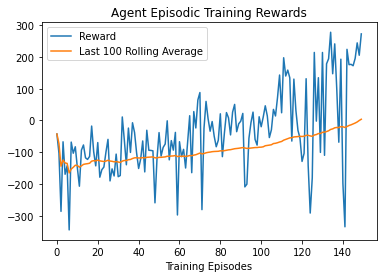

In [78]:
train_data = {"Reward" : total_reward_05[:train_episodes], "Last 100 Rolling Average" : rolling_avg_reward_05[:train_episodes]}
plot_results(range(0,train_episodes), "Training Episodes", train_data, "Agent Episodic Training Rewards", "train")

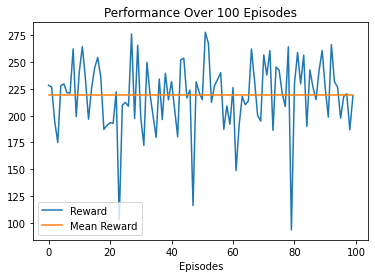

In [79]:
eval_eps=100
eval_data = {"Reward" : eval_reward_05, "Mean Reward" : np.array([np.mean(eval_reward_05)]*eval_eps)}
plot_results(range(0, eval_eps), "Episodes", eval_data, "Performance Over {} Episodes".format(eval_eps), "trained")

In [115]:
eval_reward_03 = model_recency_03.evaluate(eval_eps)

In [118]:
eval_reward_04 = model_recency_04.evaluate(eval_eps)

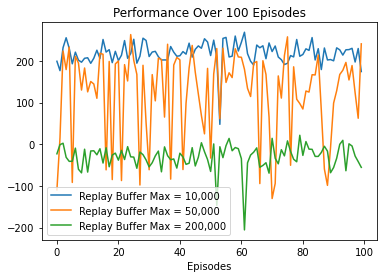

In [125]:
eval_eps=100
eval_data = {"Replay Buffer Max = 10,000" : eval_reward_05, 
             "Replay Buffer Max = 50,000" : eval_reward_04,
             "Replay Buffer Max = 200,000" : eval_reward_03}
plot_results(range(0, eval_eps), "Episodes", eval_data, "Performance Over {} Episodes".format(eval_eps), "buffer")

In [133]:
eval_reward_01 = model_recency_01.evaluate(eval_eps)

In [134]:
eval_reward_06 = model_06.evaluate(eval_eps)

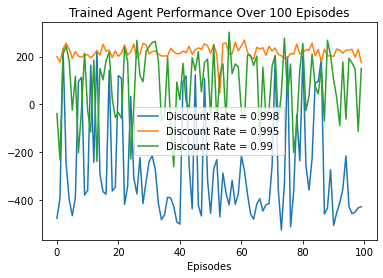

In [135]:
eval_eps=100
eval_data = {"Discount Rate = 0.998" : eval_reward_01, 
             "Discount Rate = 0.995" : eval_reward_05,
             "Discount Rate = 0.99" : eval_reward_06}
plot_results(range(0, eval_eps), "Episodes", eval_data, "Trained Agent Performance Over {} Episodes".format(eval_eps), "gamma")

In [139]:
eval_reward_08 = model_08.evaluate(eval_eps)

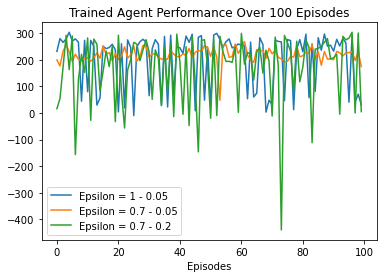

In [140]:
eval_eps=100
eval_data = {"Epsilon = 1 - 0.05" : eval_reward, 
             "Epsilon = 0.7 - 0.05" : eval_reward_05,
             "Epsilon = 0.7 - 0.2" : eval_reward_08}
plot_results(range(0, eval_eps), "Episodes", eval_data, "Trained Agent Performance Over {} Episodes".format(eval_eps), "epsilon")